# Case Study 2
You've been hired as a junior data scientist for Banco Federal de Financas in Aveiro, Portugal. They just finished a mjaor telemarketing campaign and management was not happy with the results. Your team is to help them create a more targeted campaign through machine learning.

The stakeholders want to focus on three particularly interested areas:
1. Finding interesting customer segments based on their previous marketing campaing.
2. Finding a way to identify the types of customers most likely to respond favorably to future marketing campaigns.
3. Proving to a skeptical stakeholder that a targeted campaign based on data science will significantly outperform a campaign made up of randomly selected customers.


# Imports and Dataframe Setup
Begin with training the [bank dataset](./Module%202/bank.csv) provided. Things to look for could be data types, ranges, and meanings of each feature from the [data dictionary](./Module%202/bank-dictionary.txt).

In [73]:
# Do some dataset analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import heapq
import joblib
from IPython.display import display
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

Build the dataframes separate from the imports in the case of the need of additional libraries.

In [4]:
# Build the dataframes
df = pd.read_csv('./Module 2/bank.csv')
df_test = pd.read_csv('./Module 2/bank_holdout_test.csv')
df_mini = pd.read_csv('./Module 2/bank_holdout_test_mini.csv')
targets_mini = pd.read_csv('./Module 2/bank_holdout_test_mini_answers.csv')

In [5]:
display(df.info())
display(df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37069 entries, 0 to 37068
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             37069 non-null  int64  
 1   job             37069 non-null  object 
 2   marital         37069 non-null  object 
 3   education       37069 non-null  object 
 4   default         37069 non-null  object 
 5   housing         37069 non-null  object 
 6   loan            37069 non-null  object 
 7   contact         37069 non-null  object 
 8   month           37069 non-null  object 
 9   day_of_week     37069 non-null  object 
 10  campaign        37069 non-null  int64  
 11  pdays           37069 non-null  int64  
 12  previous        37069 non-null  int64  
 13  poutcome        37069 non-null  object 
 14  emp.var.rate    37069 non-null  float64
 15  cons.price.idx  37069 non-null  float64
 16  cons.conf.idx   37069 non-null  float64
 17  euribor3m       37069 non-null 

None

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Functions and methodologies for categorical encoding.

In [6]:
def map_job_category(job_str):
    if job_str in job_map["unpaid"]:
        return 0
    elif job_str in job_map["low_paid"]:
        return 1
    else:
        return 2

def map_education_category(edu_str):
    if edu_str in education_map["educated"]:
        return 1
    else:
        return 0

def map_debt_category(debt_str):
    if debt_str in debt_map["yes"]:
        return 1
    else:
        return 0

day_map = {
    'mon': 2,
    'tue': 3,
    'wed': 4,
    'thu': 5,
    'fri': 6
}
month_map = {
    'mar': 3,
    'apr': 4,
    'may': 5,
    'jun': 6,
    'jul': 7,
    'aug': 8,
    'sep': 9,
    'oct': 10,
    'nov': 11,
    'dec': 12
}
poutcome_map = {
    'failure': -1,
    'nonexistent': 0,
    'success': 1
}
job_map = {
    "unpaid": ["unemployed", "retired", "student"],
    "low_paid": ["admin.", "blue-collar", "services", "housemaid"],
    "high_paid": ["entrepreneur", "management", "self-employed", "technician"]
}
debt_map = {
    "yes": ["yes"],
    "no": ["no", "unknown"]
}
education_map = {
    "educated": ["university.degree", "professional.course"]
}
cat_cols = [
    "job",
    "marital",
    "education",
    "default",
    "housing",
    "loan",
    "contact",
    "month",
    "day_of_week",
    "poutcome"
]
num_cols = [
    "age",
    "campaign",
    "emp.var.rate",
    "cons.price.idx",
    "cons.conf.idx",
    "euribor3m",
    "nr.employed",
    "pdays_numeric",
    "previous"
]

# Dataset Transformations

In [7]:
# Consider using LabelEncoder instead of this
encoder = LabelEncoder()
df_mini['day_of_week'] = df_mini['day_of_week'].map(day_map)
df_mini['month'] = df_mini['month'].map(month_map)
df_mini['marital'] = df_mini['marital'].map(lambda x: 0 if x == 'divorced' else 2 if x == 'married' else 1)
df_mini['contact'] = df_mini['contact'].map(lambda x: 0 if x == 'telephone' else 1)
df_mini['job'] = df_mini['job'].map(map_job_category)
df_mini['education'] = df_mini['education'].map(map_education_category)
df_mini['housing'] = df_mini['housing'].map(map_debt_category)
df_mini['loan'] = df_mini['loan'].map(map_debt_category)
df_mini['pdays'] = df_mini['pdays'].map(lambda x: 0 if x == 999 else x)

df_mini['default'] = encoder.fit_transform(df_mini['default'])
df_mini['poutcome'] = encoder.fit_transform(df_mini['poutcome'])

combined_mini = pd.DataFrame(df_mini)
combined_mini['y'] = targets_mini

df['day_of_week'] = df['day_of_week'].map(day_map)
df['month'] = df['month'].map(month_map)
df['marital'] = df['marital'].map(lambda x: 0 if x == 'divorced' else 2 if x == 'married' else 1)
df['contact'] = df['contact'].map(lambda x: 0 if x == 'telephone' else 1)
df['job'] = df['job'].map(map_job_category)
df['education'] = df['education'].map(map_education_category)
df['housing'] = df['housing'].map(map_debt_category)
df['loan'] = df['loan'].map(map_debt_category)
df['pdays'] = df['pdays'].map(lambda x: 0 if x == 999 else x)
df['y'] = df['y'].map(lambda x: 0 if x == 'no' else 1)

df['default'] = encoder.fit_transform(df['default'])
df['poutcome'] = encoder.fit_transform(df['poutcome'])

In [ ]:
# ?probably? exclude default
# This takes like 10 minutes to run
sns.pairplot(data=df, hue='y')
plt.savefig('.\\Module 2\\matrix_plot.png', dpi=300)

Normalizing the data

In [8]:
scaler = MinMaxScaler()

MnMxSclr = scaler.fit_transform(df)
MiniSclr = scaler.fit_transform(combined_mini)

# Convert the result back to a DataFrame
df_MnMxSclr = pd.DataFrame(MnMxSclr, columns=df.columns)
df_miniSclr = pd.DataFrame(MiniSclr, columns=combined_mini.columns)

# print(normalized_df)
df_MnMxSclr.head(5)
# df_MnMxSclr['y'].value_counts()

# Although, this successfully applies, it has little to no impact on the outcome, in fact it may have made it worse

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,0.481481,0.5,1.0,0.0,0.0,0.0,0.0,0.0,0.222222,0.0,0.0,0.0,0.0,0.5,0.9375,0.698753,0.60251,0.957379,0.859735,0.0
1,0.493827,0.5,1.0,0.0,0.5,0.0,0.0,0.0,0.222222,0.0,0.0,0.0,0.0,0.5,0.9375,0.698753,0.60251,0.957379,0.859735,0.0
2,0.246914,0.5,1.0,0.0,0.0,1.0,0.0,0.0,0.222222,0.0,0.0,0.0,0.0,0.5,0.9375,0.698753,0.60251,0.957379,0.859735,0.0
3,0.283951,0.5,1.0,0.0,0.0,0.0,0.0,0.0,0.222222,0.0,0.0,0.0,0.0,0.5,0.9375,0.698753,0.60251,0.957379,0.859735,0.0
4,0.481481,0.5,1.0,0.0,0.0,0.0,1.0,0.0,0.222222,0.0,0.0,0.0,0.0,0.5,0.9375,0.698753,0.60251,0.957379,0.859735,0.0


# Training and Predicting

Declarations

In [9]:
clf = DecisionTreeClassifier(random_state=117, max_depth=3)
clf_mini = DecisionTreeClassifier(random_state=117, max_depth=3)

Training

In [10]:
X = df_MnMxSclr.drop(columns=['y'])
y = df_MnMxSclr['y']

X_mini = combined_mini.drop(columns=['y'])
y_mini = combined_mini['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=117)
X_tn_mini, X_tst_mini, y_tn_mini, y_tst_mini = train_test_split(X_mini, y_mini, train_size=0.8, test_size=0.2, random_state=117)
clf.fit(X_train, y_train)
clf_mini.fit(X_tn_mini, y_tn_mini)

pred_main = clf.predict(X_test)
pred_mini = clf_mini.predict(X_tst_mini)
acc_main = accuracy_score(y_test, pred_main)
acc_mini = accuracy_score(y_tst_mini, pred_mini)
display(acc_main)
display(acc_mini)

0.8970865929322903

0.8902439024390244

# Heat Map

<Axes: >

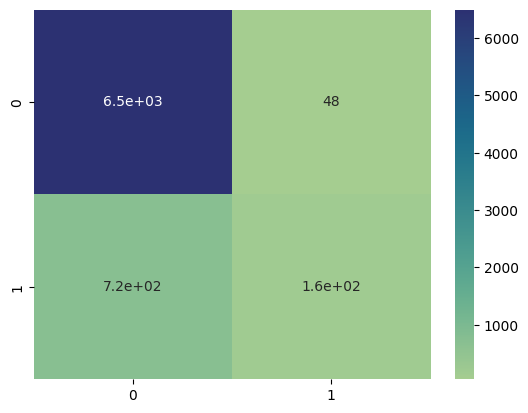

In [11]:
cm = confusion_matrix(y_test, pred_main)
sns.heatmap(cm, annot=True, cmap='crest')

# Visualizing the decision tree

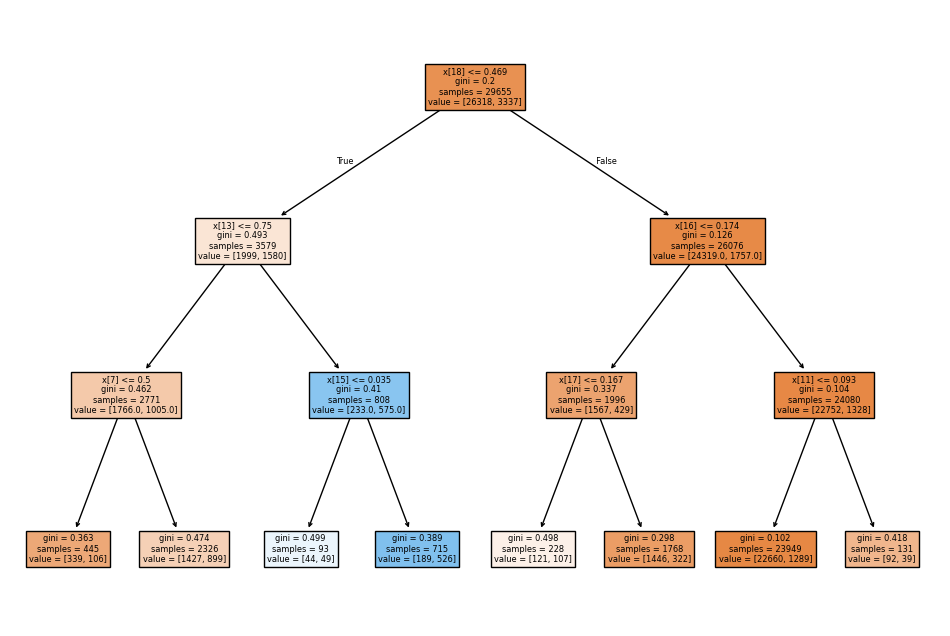

In [12]:
plt.figure(figsize=(12, 8))
plot_tree(clf, filled=True)
plt.show()


# Evaluating Feature Importance

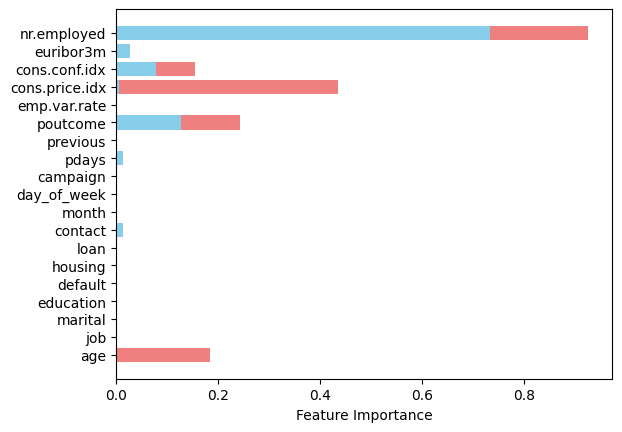

In [13]:
feat_import = clf.feature_importances_
feat_mini = clf_mini.feature_importances_

# Print the feature importances
# for feature, importance in zip(df_MnMxSclr.columns, feat_import):
    # print(f"{feature}: {importance:.4f}")

# Plot the feature importances
plt.barh(df_MnMxSclr.drop(columns=['y']).columns, feat_import, color='skyblue', label='Main')
plt.barh(df_MnMxSclr.drop(columns=['y']).columns, feat_mini, color='lightcoral', left=feat_import, label='Mini')
plt.xlabel("Feature Importance")
# plt.title("Feature Importances in Decision Tree")
plt.show()

# Prediction across datasets

In [14]:
pred_comp = clf.predict(df_mini)
pred_comp_mini = clf_mini.predict(df.drop(columns=['y']))
acc_comp = accuracy_score(targets_mini, pred_comp)
acc_comp_mini = accuracy_score(df['y'], pred_comp_mini)
display(acc_comp)
display(acc_comp_mini)

0.8853658536585366

0.8761229059321806

Heat Map on Mini Holdout

<Axes: >

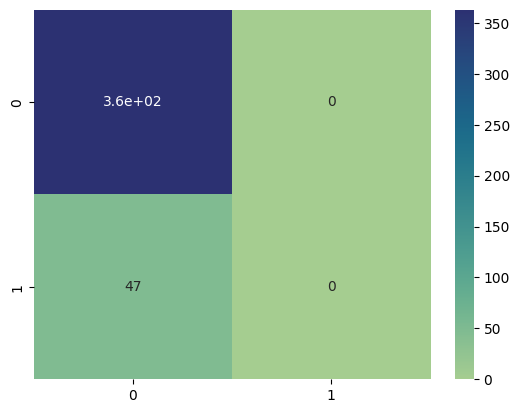

In [15]:
cm_mini = confusion_matrix(targets_mini, pred_comp)
sns.heatmap(cm_mini, annot=True, cmap='crest')

# Balancing Class Weights

Use the built in balancing feature in the decision tree classifier to balance the class weights

In [16]:
clf_bl = DecisionTreeClassifier(class_weight='balanced', random_state=117, max_depth=3)
clf_bl_mini = DecisionTreeClassifier(class_weight='balanced', random_state=117, max_depth=3)

Split the data and have it trained with the balanced configuration

In [17]:
X_train_bl, X_test_bl, y_train_bl, y_test_bl = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=117)
X_tn_bl_mini, X_tst_bl_mini, y_tn_bl_mini, y_tst_bl_mini = train_test_split(X_mini, y_mini, train_size=0.8, test_size=0.2, random_state=117)
clf_bl.fit(X_train_bl, y_train_bl)
clf_bl_mini.fit(X_tn_bl_mini, y_tn_bl_mini)

pred_bl = clf_bl.predict(X_test_bl)
pred_bl_mini = clf_bl_mini.predict(X_tst_bl_mini)
acc_bl = accuracy_score(y_test_bl, pred_bl)
acc_bl_mini = accuracy_score(y_tst_bl_mini, pred_bl_mini)
display(acc_bl)
display(acc_bl_mini)

0.8346371729161046

0.9024390243902439

Visualize the balanced

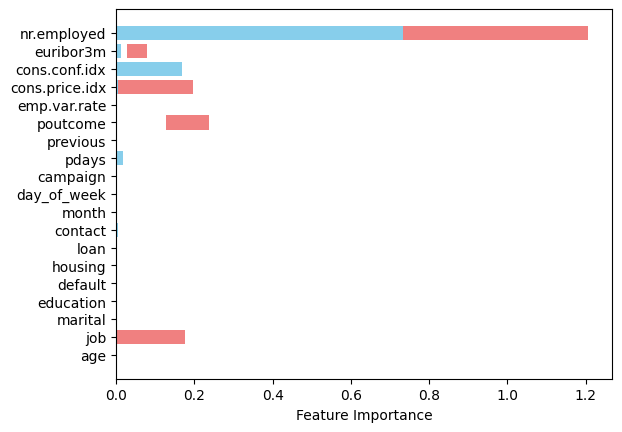

In [18]:
feat_bl = clf_bl.feature_importances_
feat_bl_mini = clf_bl_mini.feature_importances_

plt.barh(df_MnMxSclr.drop(columns=['y']).columns, feat_bl, color='skyblue', label='Balanced')
plt.barh(df_MnMxSclr.drop(columns=['y']).columns, feat_bl_mini, color='lightcoral', left=feat_import, label='Balanced Mini')
plt.xlabel("Feature Importance")
plt.show()

Training with the employed column dropped.

In [19]:
df_MnMxSclr.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,0.481481,0.5,1.0,0.0,0.0,0.0,0.0,0.0,0.222222,0.0,0.0,0.0,0.0,0.5,0.9375,0.698753,0.60251,0.957379,0.859735,0.0
1,0.493827,0.5,1.0,0.0,0.5,0.0,0.0,0.0,0.222222,0.0,0.0,0.0,0.0,0.5,0.9375,0.698753,0.60251,0.957379,0.859735,0.0
2,0.246914,0.5,1.0,0.0,0.0,1.0,0.0,0.0,0.222222,0.0,0.0,0.0,0.0,0.5,0.9375,0.698753,0.60251,0.957379,0.859735,0.0
3,0.283951,0.5,1.0,0.0,0.0,0.0,0.0,0.0,0.222222,0.0,0.0,0.0,0.0,0.5,0.9375,0.698753,0.60251,0.957379,0.859735,0.0
4,0.481481,0.5,1.0,0.0,0.0,0.0,1.0,0.0,0.222222,0.0,0.0,0.0,0.0,0.5,0.9375,0.698753,0.60251,0.957379,0.859735,0.0


In [22]:
clf_ne = DecisionTreeClassifier(random_state=117, max_depth=3)
clf_ne_mini = DecisionTreeClassifier(random_state=117, max_depth=3)

X_no_emp = df_MnMxSclr.drop(columns=['nr.employed', 'y'])
y_no_emp = df_MnMxSclr['y']

X_no_emp_mini = combined_mini.drop(columns=['nr.employed', 'y'])
y_no_emp_mini = combined_mini['y']

X_trn_no_emp, X_tst_no_emp, y_trn_no_emp, y_tst_no_emp = train_test_split(X_no_emp, y_no_emp, train_size=0.85, test_size=0.15, random_state=117)
X_trn_ne_mini, X_tst_ne_mini, y_trn_ne_mini, y_tst_ne_mini = train_test_split(X_no_emp_mini, y_no_emp_mini, train_size=0.85, test_size=0.15, random_state=117)

clf_ne.fit(X_trn_no_emp, y_trn_no_emp)
clf_ne_mini.fit(X_trn_ne_mini, y_trn_ne_mini)

pred_no_emp = clf_ne.predict(X_tst_no_emp)
pred_ne_mini = clf_ne_mini.predict(X_tst_ne_mini)
acc_no_emp = accuracy_score(y_tst_no_emp, pred_no_emp)
acc_ne_mini = accuracy_score(y_tst_ne_mini, pred_ne_mini)
display(acc_no_emp)
display(acc_ne_mini)

0.8962416831505124

0.8709677419354839

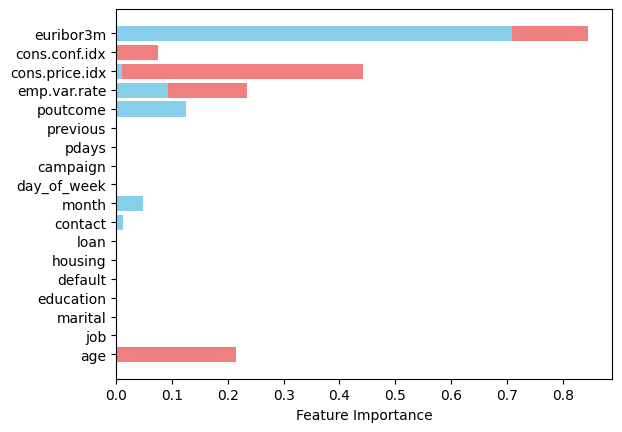

In [31]:
feat_ne = clf_ne.feature_importances_
feat_ne_mini = clf_ne_mini.feature_importances_

plt.barh(df_MnMxSclr.drop(columns=['nr.employed', 'y']).columns, feat_ne, color='skyblue', label='Main')
plt.barh(df_MnMxSclr.drop(columns=['nr.employed', 'y']).columns, feat_ne_mini, color='lightcoral', left=feat_ne, label='Mini')
plt.xlabel("Feature Importance")
plt.show()

# Crazy combination experiment

Create an array of all the columns that are classifications

Create a looping process to iterate over each combination

In [52]:
feats = df.drop(columns=['y']).columns
mdl_combis = []
acc_combis = []
mdls = []
min_feat_count = 2


for r in range(min_feat_count, len(feats) + 1):
    for combi in itertools.combinations(feats, r):
        mdl_combis.append(list(combi))
        # 

# pred_no_emp = clf_ne.predict(X_tst_no_emp)
# acc_no_emp = accuracy_score(y_tst_no_emp, pred_no_emp)
# display(acc_no_emp)

In [53]:
# df_MnMxSclr[['age', 'y']].head(5)
# mdls[0]
# df_MnMxSclr[mdls[700]].head(5)
len(mdl_combis) # = 524268

524268

create each combnation model and save them into an array.

In [ ]:
# Should take approximately 2 hours

y_tmp = df_MnMxSclr['y']

for i in range(0, len(mdl_combis)):
    clf_tmp = DecisionTreeClassifier(random_state=117, max_depth=3)
    X_tmp = df_MnMxSclr[mdl_combis[i]]
    X_tmp_trn, X_tmp_tst, y_tmp_trn, y_tmp_tst = train_test_split(X_tmp, y_tmp, train_size=0.85, test_size=0.15, random_state=117)

    clf_tmp.fit(X_tmp_trn, y_tmp_trn)
    pred_tmp = clf_tmp.predict(X_tmp_tst)
    acc_tmp = accuracy_score(y_tmp_tst, pred_tmp)
    mdls.append(clf_tmp)
    acc_combis.append(acc_tmp)

In [ ]:
# evaluating the data
largest_acc = heapq.nlargest(5, enumerate(acc_combis), key=lambda x: x[1])
index_pair = {index: value for index, value in largest_acc}

In [69]:
index_pair

{1104: 0.8978600971048373,
 1920: 0.8978600971048373,
 2600: 0.8978600971048373,
 3160: 0.8978600971048373,
 3615: 0.8978600971048373}

In [72]:
# feat_ne = clf_ne.feature_importances_
# feat_ne_mini = clf_ne_mini.feature_importances_

# plt.barh(df_MnMxSclr.drop(columns=['nr.employed', 'y']).columns, feat_ne, color='skyblue', label='Main')
# plt.barh(df_MnMxSclr.drop(columns=['nr.employed', 'y']).columns, feat_ne_mini, color='lightcoral', left=feat_ne, label='Mini')
# plt.xlabel("Feature Importance")
# plt.show()

# mdls[1104]
display(mdl_combis[1104])
display(mdl_combis[1920])
display(mdl_combis[2600])
display(mdl_combis[3160])
display(mdl_combis[3615])

['pdays', 'euribor3m', 'nr.employed']

['age', 'pdays', 'euribor3m', 'nr.employed']

['job', 'pdays', 'euribor3m', 'nr.employed']

['marital', 'pdays', 'euribor3m', 'nr.employed']

['education', 'pdays', 'euribor3m', 'nr.employed']

In [74]:
# Attempting to save the models
joblib.dump(mdls, 'Module 2\\array_of_models.pkl')

['Module 2\\array_of_models.pkl']

In [75]:
joblib.dump(mdl_combis, 'Module 2\\array_of_feature_combinations.pkl')
joblib.dump(acc_combis, 'Module 2\\array_of_indeces_accuracy_scores.pkl')

['Module 2\\array_of_indeces_accuracy_scores.pkl']

In [ ]:
# Example of loading things back in
loaded_models = joblib.load('Module 2\\array_of_models.pkl')
